# An example of EEG preprocessing with MNE python

This is an example on how to preprocess EEG data with [MNE](https://mne.tools/stable/index.html). Obviously there are many ways to preprocess EEG data, this template is intended for people using [Hidden semi-Markov Models with pattern analysis (HMP)](https://github.com/GWeindel/hsmm_mvpy) but others might find it useful.

I usually preprocess EEG in a notebook using MNE and save one notebook per participant I prepreocessed. This allows me to later retrieve the information on what particular steps were taken for each individual and also eventually change some steps without having to run all the notebook again.

In [3]:
name_subj = "S8"#Data is dynamically read and saved based on this string, adapt to the number of your participant

#Necessary library
import mne#preprocessing and plotting
import os#file and path handling
import numpy as np#Numerical computations
import pandas as pd#data frame handling
import matplotlib.pyplot as plt#plotting

print(f'MNE version is {mne.__version__}')
%matplotlib inline
#plot within notebook, useful for later sharing
EEG_data_path = './'#Path where the EEG data, windows user should probably replace the way path are declared using os.path.join()

MNE version is 1.2.2


UsageError: unrecognized arguments: withijn notebook, useful for later sharing


# Reading raw BDF

This data was recorded using a biosemi 32 channel system.

Extracting EDF parameters from /home/gweindel/owncloud/projects/supervisions/2023/Kenneth_contrast/EEG_data/raw/S8.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2779135  =      0.000 ...  2713.999 secs...
Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished
/tmp/ipykernel_15891/1665628530.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmin=500, picks='eeg');


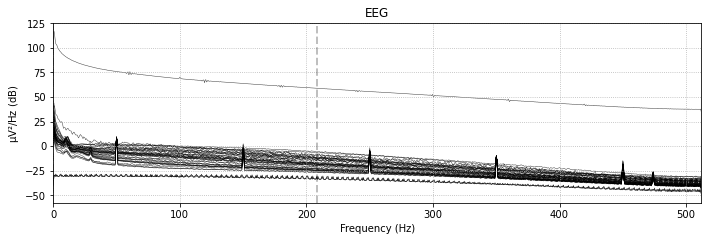

<Info | 7 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 41 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 208.0 Hz
 meas_date: 2023-03-30 13:35:58 UTC
 nchan: 42
 projs: []
 sfreq: 1024.0 Hz
>

In [2]:
raw = mne.io.read_raw_bdf(EEG_data_path+'raw/%s.bdf'%name_subj,preload=True, verbose=True)
raw.plot_psd(tmin=500, picks='eeg');#First glimpse at the coarse frequnecy composition of the data
plt.show()
raw.info#Info structure about the data

#  Setting up bipolar references and montage

Note that everything is done inplace, meaning that e.g. if you drop channels they will no longer be present in the original ```raw``` variable

In [3]:
raw.drop_channels(['EXG6','EXG7','EXG8'])#Dropping empty external channels (shouldn't have been recorded

# Creating the bipolar montage, the 3 first are the EOG
mne.set_bipolar_reference(raw,anode=['EXG1','EXG3'],cathode=['EXG2','A1'],ch_name=['EOGH','EOGV'],copy=False, drop_refs=False) #creating horizontal and vertical EOGs
#Drop refs in this case should be false as we don't want to drop Fp1
raw.set_channel_types({'EOGH':'eog','EOGV':'eog','EXG4':'misc','EXG5':'misc','Erg1':'misc',
                      'EXG1':'misc','EXG2':'misc','EXG3':'misc','EXG4':'misc'})#declare type to avoid confusion with EEG channels
#Renaming electrodes
dict_to_biosemi = dict(zip(raw.copy().pick_types(eeg=True).ch_names, mne.channels.make_standard_montage('biosemi32').ch_names))#convert names to biosemi 32 frame
raw.rename_channels(dict_to_biosemi)
raw.set_montage('biosemi32')#Get electrode positions of a standard montage of the electrodes, MNE also allows to provide positions if they are recorded

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=2, n_times=2779136
    Range : 0 ... 2779135 =      0.000 ...  2713.999 secs
Ready.
Added the following bipolar channels:
EOGH, EOGV


<RawEDF | S8.bdf, 41 x 2779136 (2714.0 s), ~869.4 MB, data loaded>

We see that the info object is now updated according to the modifications done

# Checking for bad electrodes

Visual inspection to detect fault electrodes (flat, very noisy, unstable for long period of times). Do not worry about occasional glitches as these will be fixed at the last stage of the pipeline

In [4]:
%matplotlib qt
raw.set_eeg_reference('average')#For electrode check only
raw.plot(block=True, n_channels=36, scalings=100e-6);#plotting function, block argument stops notebook execution, useful if you just want to run the whole notebook

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Using matplotlib as 2D backend.
Channels marked as bad:
['P4']


Additionally it is possible to check bridged electrode (https://mne.tools/dev/auto_examples/preprocessing/eeg_bridging.html) but with 32 electrodes that is unlikely

In [5]:
raw.info['bads'] 

['P4']

## REST reference

Then we apply a REST reference (see https://iopscience.iop.org/article/10.1088/0967-3334/22/4/305/meta)

In [6]:
# Setting the reference, REST 
sphere = mne.make_sphere_model('auto', 'auto', raw.info, verbose=False)
src = mne.setup_volume_source_space(sphere=sphere, exclude=30., pos=15., verbose=False)
forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere, verbose=False)
raw.set_eeg_reference('REST', forward=forward);

EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    31 out of 32 channels remain after picking


<RawEDF | S8.bdf, 41 x 2779136 (2714.0 s), ~869.4 MB, data loaded>

# Filtering

Low, high pass filter + notchfilter at 50Hz

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.1s finished


Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished


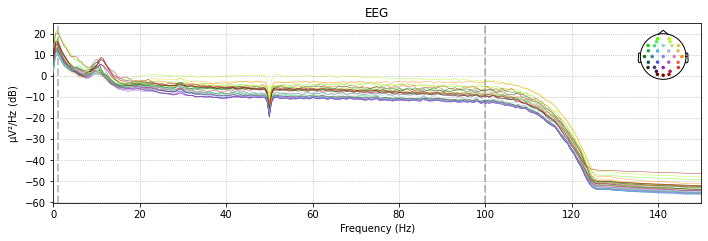

In [7]:
%matplotlib inline
raw.filter(1, 100, None,l_trans_bandwidth='auto',filter_length='auto',phase='zero') #Filtering between 1 and 100 Hz
raw.notch_filter(freqs=50)#In this experiment 50Hz for all participants so notch filter needed
raw.plot_psd(tmin=500, fmax=150, picks='eeg')#rechecking frequency decomposition
plt.show()

I save the data, hence saving the montage, the low-pass filtered data, the (eventual) annotation of the bad channel

In [8]:
raw.save(EEG_data_path+"preprocessing/pre_rejection_%s.fif"%name_subj,overwrite=True) #save data in .fif format

Overwriting existing file.
Writing /home/gweindel/owncloud/projects/supervisions/2023/Kenneth_contrast/EEG_data/preprocessing/pre_rejection_S8.fif


/tmp/ipykernel_15891/2581248364.py:1: RuntimeWarning: This filename (/home/gweindel/owncloud/projects/supervisions/2023/Kenneth_contrast/EEG_data/preprocessing/pre_rejection_S8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(EEG_data_path+"preprocessing/pre_rejection_%s.fif"%name_subj,overwrite=True) #sauvegarde les données au format fif pour la suite des traitements


Closing /home/gweindel/owncloud/projects/supervisions/2023/Kenneth_contrast/EEG_data/preprocessing/pre_rejection_S8.fif
[done]


# Rejecting artefacts

First we recover the events from the trigger channel

In [9]:
events = mne.find_events(raw)#In MNE for Biosemi the trigger is automatically found


Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
4465 events found
Event IDs: [    3     4     5     6     7     8     9    10    11    12    13    14
    15    16    17    18    19    20    21    22    23    24    25    26
    27    28    29    30    31    32    33    34    35    36    37    38
    39    40    41    42    43    44    45    46    47    48    49    50
    51    52    53    54    55    56    57    58    59    60    61    62
    63    64    65    66    67    68    69    70    71    72    73    74
    75    76    77    78    79    80    81    82    83    84    85    86
    87    88    89    90    91    92    93    94    95    99   100   101
   199   200   201 65790]


We can display every events in the experiment found in the trigger channel

/tmp/ipykernel_15891/4186682001.py:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events);


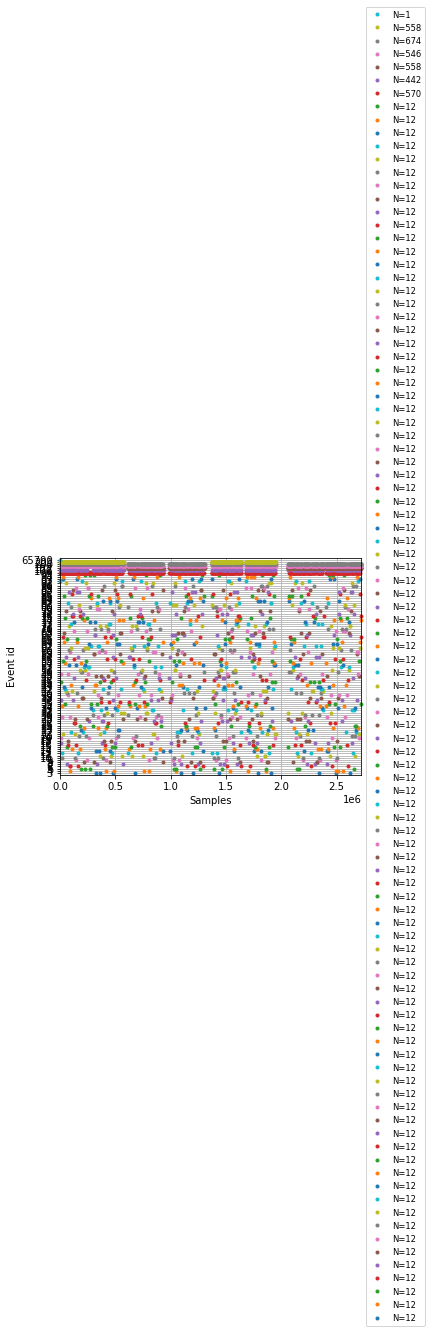

In [10]:
mne.viz.plot_events(events);

Events have the following structure [sample, offset of the trigger channel, value of the trigger]

In [11]:
events[1:11]

array([[2518,    0,  201],
       [2636,    0,   99],
       [2764,    0,   92],
       [3362,    0,  100],
       [4517,    0,  201],
       [4635,    0,  199],
       [4758,    0,   19],
       [5345,    0,  100],
       [6903,    0,  201],
       [7021,    0,   99]])

We then parse the codes according to how we coded the experiment (hence function on how you defined your triggers)

In [12]:
all_events = np.array(np.unique(events[:,2]))
stim_trigger = all_events[all_events<99]
conditions_to_trigger = {"acc":101, "spd":201}
side_to_trigger = {"left":99, "right":199}
resp_trigger = [100,200]

Just for visualisation purposes we define separate colors for stimulus vs response triggers vs others

In [13]:
stim = np.array([x for x in events if x[-1] in  stim_trigger])
resp = np.array([x for x in events if x[-1] in  resp_trigger])

color_dict = {k:'b' for k in stim_trigger}
color_dict.update({k:'g' for k in resp_trigger})
color_dict.update({k:'gray' for k in set.difference(set(all_events),set(stim_trigger), set(resp_trigger))})

## Correcting stim onset based on photodiode

In this (specific) case we have the recording of a photodiode so we'll use that info to know when the screen was actually refreshed

In [14]:
def find_onset_pd(data, event_sample, baseline=500):
    '''
    Detects onset of stim through std deviation of photodiode signal
    '''
    try:
        index = np.where(data <0)[0][0]
    except:
        return(event_sample)
    if event_sample - (index-baseline+event_sample) >0:
        print('inconsistent photodiode detected onset')
        return(event_sample)
    else:
        return(index-baseline+event_sample)

len([x[0] for x in events if x[2] in stim_trigger])#Print the number of total events having a stimulus code

1116

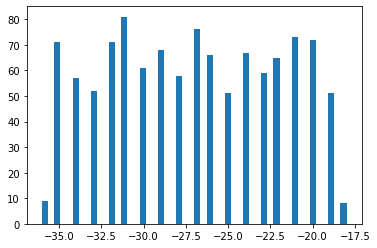

1116


In [16]:
photodiode = raw.copy().pick(['Erg1']).get_data()[0]
baseline = 500
new_events = events.copy()
onsets = []
for i in np.arange(len(events)):
    if events[i,2] in stim_trigger:
        onsets.append(find_onset_pd(photodiode[events[i,0]-baseline:events[i,0]+150], events[i,0], baseline=baseline))
        new_events[i,0] = onsets[-1]
%matplotlib inline
diffs = events[:,0] - new_events[:,0]
diffs = diffs[diffs != 0]
plt.hist(diffs,bins=50);
plt.show()
print(sum(events[:,0] != new_events[:,0]))#check how many events changed, should be the same as above

1116 stimulus events had their location (in samples) corrected according to the value of the photodiode. For the record, the photodiode is just a channel with data (see below) so we can just use plain python to find where the onset of the stimulus is located

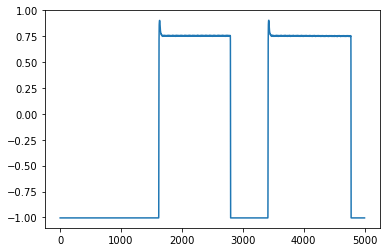

In [17]:
plt.plot(photodiode[:5000])
plt.show()

We now replace the photodiode corrected events

In [18]:
events = new_events
raw.add_events(events, replace=True)

# ICA

To remove artifacts we'll use independent component analysis (see MNE's tutorials, e.g. https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#sphx-glr-auto-tutorials-preprocessing-40-artifact-correction-ica-py)

## Preparing for ICA

We fit the ICA on the continuous EEG signal but to avoid taking beginning and end of the recording as well as (eventual) breaks in the experiment, which are often very noisy, we annotate the long sections without stimulus triggers.

### Annotation of very long RTs/breaks

In [19]:
stim_events = np.array([list(x) for x in events if x[2] in stim_trigger])

estimated_duration_breaks = 6 #seconds
onset_breaks = stim_events[np.where(np.diff(stim_events[:,0], n=1) > (raw.info['sfreq']*estimated_duration_breaks))][:,0]/raw.info['sfreq'] #detecting latencies between triggers > x sec
offset_breaks = np.flip(np.flip(stim_events)[np.where(np.diff(np.flip(stim_events[:,0]), n=1) < -(raw.info['sfreq']*estimated_duration_breaks))])[:,0]/raw.info['sfreq']

onset_breaks = onset_breaks + 3 #add 3 sec after last stimulus trigger
offset_breaks = offset_breaks - .6 #removes 600 msec before next stimulus trigger

onset_breaks = np.insert(onset_breaks,0,0)#just adding start of the recording to the breaks
onset_breaks = np.insert(onset_breaks,-1, stim_events[-1,0]/raw.info['sfreq']+3)#just adding end of the recording to the breaks

offset_breaks = np.insert(offset_breaks,0,stim_events[0,0]/raw.info['sfreq']-.6)#just adding start of the recording to the breaks
offset_breaks = np.insert(offset_breaks,-1, raw.times.max())#just adding end of the recording to the breaks


duration_breaks = np.asarray(offset_breaks) - np.asarray(onset_breaks)


print(len(duration_breaks))
break_annot = mne.Annotations(onset= np.insert(onset_breaks,0,0),#just adding start of the recording to the breaks
                           duration=np.insert(duration_breaks,0, stim_events[0,0]/raw.info['sfreq']-1),
                           description=['BAD_breaks'])
raw.set_annotations(break_annot);

9


<RawEDF | S8.bdf, 41 x 2779136 (2714.0 s), ~869.4 MB, data loaded>

9 of such periods where found and annotated so excluded from future data processing

## Adding annotations

First enter in annotation mode with ctrl+A and add a description "BAD" then remove portions where participant was clearly doing something else (scratching, blinking during stimulus presentation, weird artifacts), also remoe trials with unrecoverable noise and spread across all electrodes

In [20]:
%matplotlib qt
if 'saved_annotations_%s.csv'%(name_subj) in os.listdir('preprocessing'):
    annot_from_file = mne.read_annotations('preprocessing/saved_annotations_%s.csv'%(name_subj))
    raw.set_annotations(annot_from_file)
    raw.plot(events=events,  event_color=color_dict, remove_dc=True, n_channels=len(raw.ch_names), use_opengl=True, block=True)
    raw.annotations.save('preprocessing/saved_annotations_%s.csv'%(name_subj),overwrite=True)
else:
    raw.plot(events=events,  event_color=color_dict, remove_dc=True, n_channels=len(raw.ch_names), use_opengl=True, block=True)
    raw.annotations.save('preprocessing/saved_annotations_%s.csv'%(name_subj),overwrite=True)


Channels marked as bad:
['P4']
Overwriting existing file.


Traceback (most recent call last):
  File "/home/gweindel/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 270, in process
    func(*args, **kwargs)
  File "/home/gweindel/anaconda3/lib/python3.9/site-packages/mne/viz/_mpl_figure.py", line 189, in _close
    super()._close(event)
  File "/home/gweindel/anaconda3/lib/python3.9/site-packages/mne/viz/_mpl_figure.py", line 113, in _close
    self.mne.parent_fig.mne.child_figs.remove(self)
ValueError: list.remove(x): x not in list


Save every step up to now and before the actual fit of the ICA

In [21]:
raw.save("preprocessing/pre_ica_%s.fif"%name_subj,overwrite=True)

Overwriting existing file.
Writing /home/gweindel/owncloud/projects/supervisions/2023/Kenneth_contrast/EEG_data/preprocessing/pre_ica_S8.fif


/tmp/ipykernel_15891/217103280.py:1: RuntimeWarning: This filename (/home/gweindel/owncloud/projects/supervisions/2023/Kenneth_contrast/EEG_data/preprocessing/pre_ica_S8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save("preprocessing/pre_ica_%s.fif"%name_subj,overwrite=True)


Closing /home/gweindel/owncloud/projects/supervisions/2023/Kenneth_contrast/EEG_data/preprocessing/pre_ica_S8.fif
[done]


# Fitting ICA

###  Resampling

In [ ]:
# raw = mne.io.read_raw_fif(EEG_data_path+"preprocessing/pre_ica_%s.fif"%name_subj, preload=True)#needed just in case of restart at this point

Opening raw data file ./preprocessing/pre_ica_S8.fif...
    Range : 0 ... 2779135 =      0.000 ...  2713.999 secs
Ready.
Reading 0 ... 2779135  =      0.000 ...  2713.999 secs...


/tmp/ipykernel_13432/1339611238.py:1: RuntimeWarning: This filename (./preprocessing/pre_ica_S8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(EEG_data_path+"preprocessing/pre_ica_%s.fif"%name_subj, preload=True)


Downsampling to 500 Hz to reduce computational load. Note that while we fit the ICA on resampled data, the ICA based correction will be done on the original sampling frequency by reloading the data pre-ica before correction

In [22]:
events = mne.find_events(raw)
raw, events = raw.resample(500, events=events)#passing the events avoids generating incorrect timing in events

4465 events found
Event IDs: [    3     4     5     6     7     8     9    10    11    12    13    14
    15    16    17    18    19    20    21    22    23    24    25    26
    27    28    29    30    31    32    33    34    35    36    37    38
    39    40    41    42    43    44    45    46    47    48    49    50
    51    52    53    54    55    56    57    58    59    60    61    62
    63    64    65    66    67    68    69    70    71    72    73    74
    75    76    77    78    79    80    81    82    83    84    85    86
    87    88    89    90    91    92    93    94    95    99   100   101
   199   200   201 65790]


We rebuild the same event structure (in case you needed to rerun the notebook)

In [23]:
all_events = np.array(np.unique(events[:,2]))
stim_trigger = all_events[all_events<99]
conditions_to_trigger = {"acc":101, "spd":201}
side_to_trigger = {"left":99, "right":199}
resp_trigger = [100,200]

Fit using the fastICA algorithm implemented by MNE. Add -1 to avoid rank deficiency linked to REST reference

In [24]:
ica = mne.preprocessing.ICA(n_components = len(raw.pick_types(eeg=True).ch_names)-1, method='fastica', max_iter='auto')
ica.fit(raw)

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Omitting 184987 of 1357000 (13.63%) samples, retaining 1172013 (86.37%) samples.
Selecting by number: 30 components
Fitting ICA took 64.7s.


Method,fastica
Fit,49 iterations on raw data (1172013 samples)
ICA components,30
Explained variance,100.0 %
Available PCA components,31
Channel types,eeg
ICA components marked for exclusion,—


Save the fitted ICA

In [25]:
ica.save("preprocessing/ICA_object_%s.fif"%name_subj, overwrite=True);

Overwriting existing file.
Writing ICA solution to /home/gweindel/owncloud/projects/supervisions/2023/Kenneth_contrast/EEG_data/preprocessing/ICA_object_S8.fif...


/tmp/ipykernel_15891/3278234662.py:1: RuntimeWarning: This filename (preprocessing/ICA_object_S8.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save("preprocessing/ICA_object_%s.fif"%name_subj, overwrite=True);


### Visualizing on epochs

Now we fitted on the continuous data (minus breaks and bad portions), but we want to inspect how ICs behave at the epoch level. Hence we first epoch the data in order to take alook at those ICs

In [26]:
epochs = mne.Epochs(raw, stim, event_id=[int(x) for x in stim_trigger], tmin=-0.5, tmax=2, preload=True)#Epoch is -500ms up to 2000ms after stim, only for IC visualization

Not setting metadata
1116 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1116 events and 1251 original time points ...
613 bad epochs dropped


### Inspection 
Here we open an interactive view to inspect components based on their topologies on the scalp. Clicking on their number marks them for exclusion, clicking on the topologies opens a view of the IC on different measures (see also [[zoom on suspicious ICs]])

In [30]:
%matplotlib qt 
#%matplotlib qt opens a separate window
ica.plot_components(inst=epochs);

[<MNEFigure size 702x696 with 20 Axes>, <MNEFigure size 702x357 with 10 Axes>]

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
503 matching events found
No baseline correction applied
0 projection items activated


### ICs epoch timecourse


Here we inspect each ICs time course during the whole experiment, very usefull to understand eventual functional properties of the identified ICs. 

Not setting metadata
503 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_15891/1461552462.py:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  ica.plot_sources(epochs, block=True)


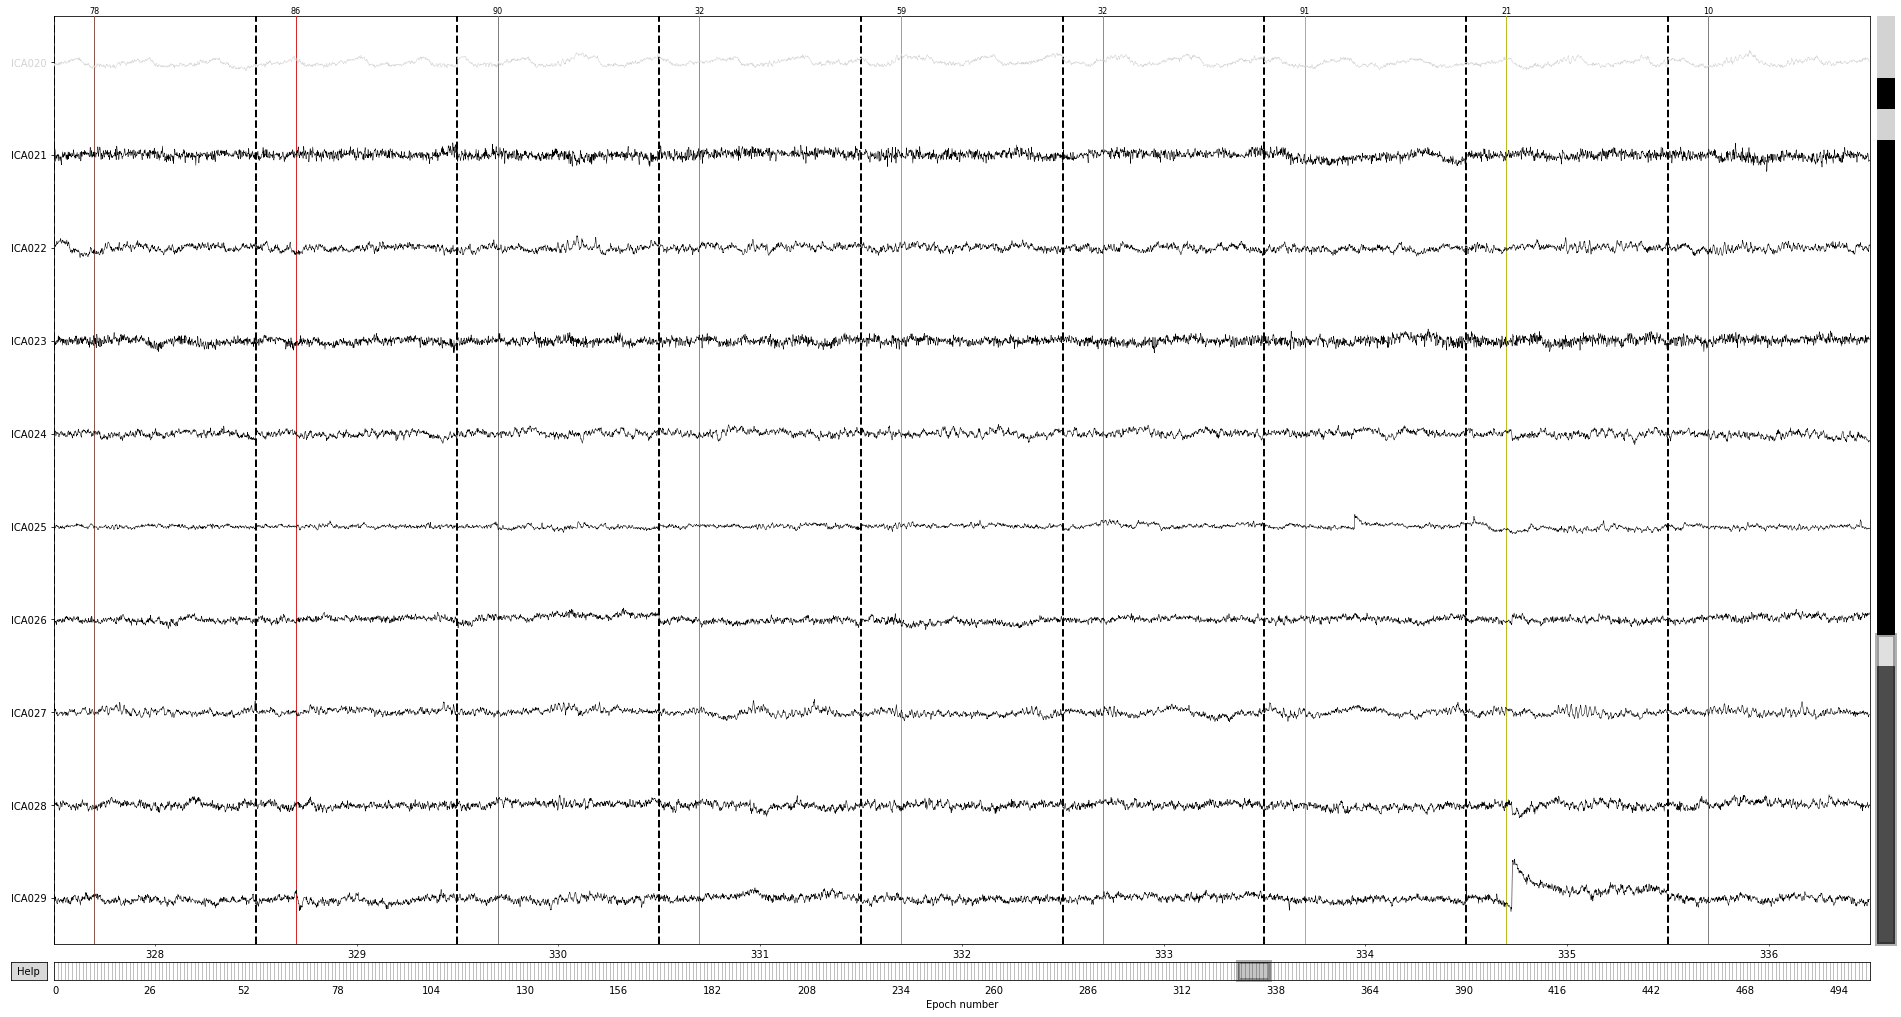

In [29]:
ica.plot_sources(epochs, block=True)# opens a dynamic window when run

### zoom on suspsicious ICs

Before exclusions I take a look at those IC that I marked to be sure that those are the ones I want to exclude. A prompt at the end of the cell takes as input the number (separated by commas) of the ICs I really want to remove

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
503 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
503 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
503 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
503 matching events found
No baseline correction applied
0 projection items activated


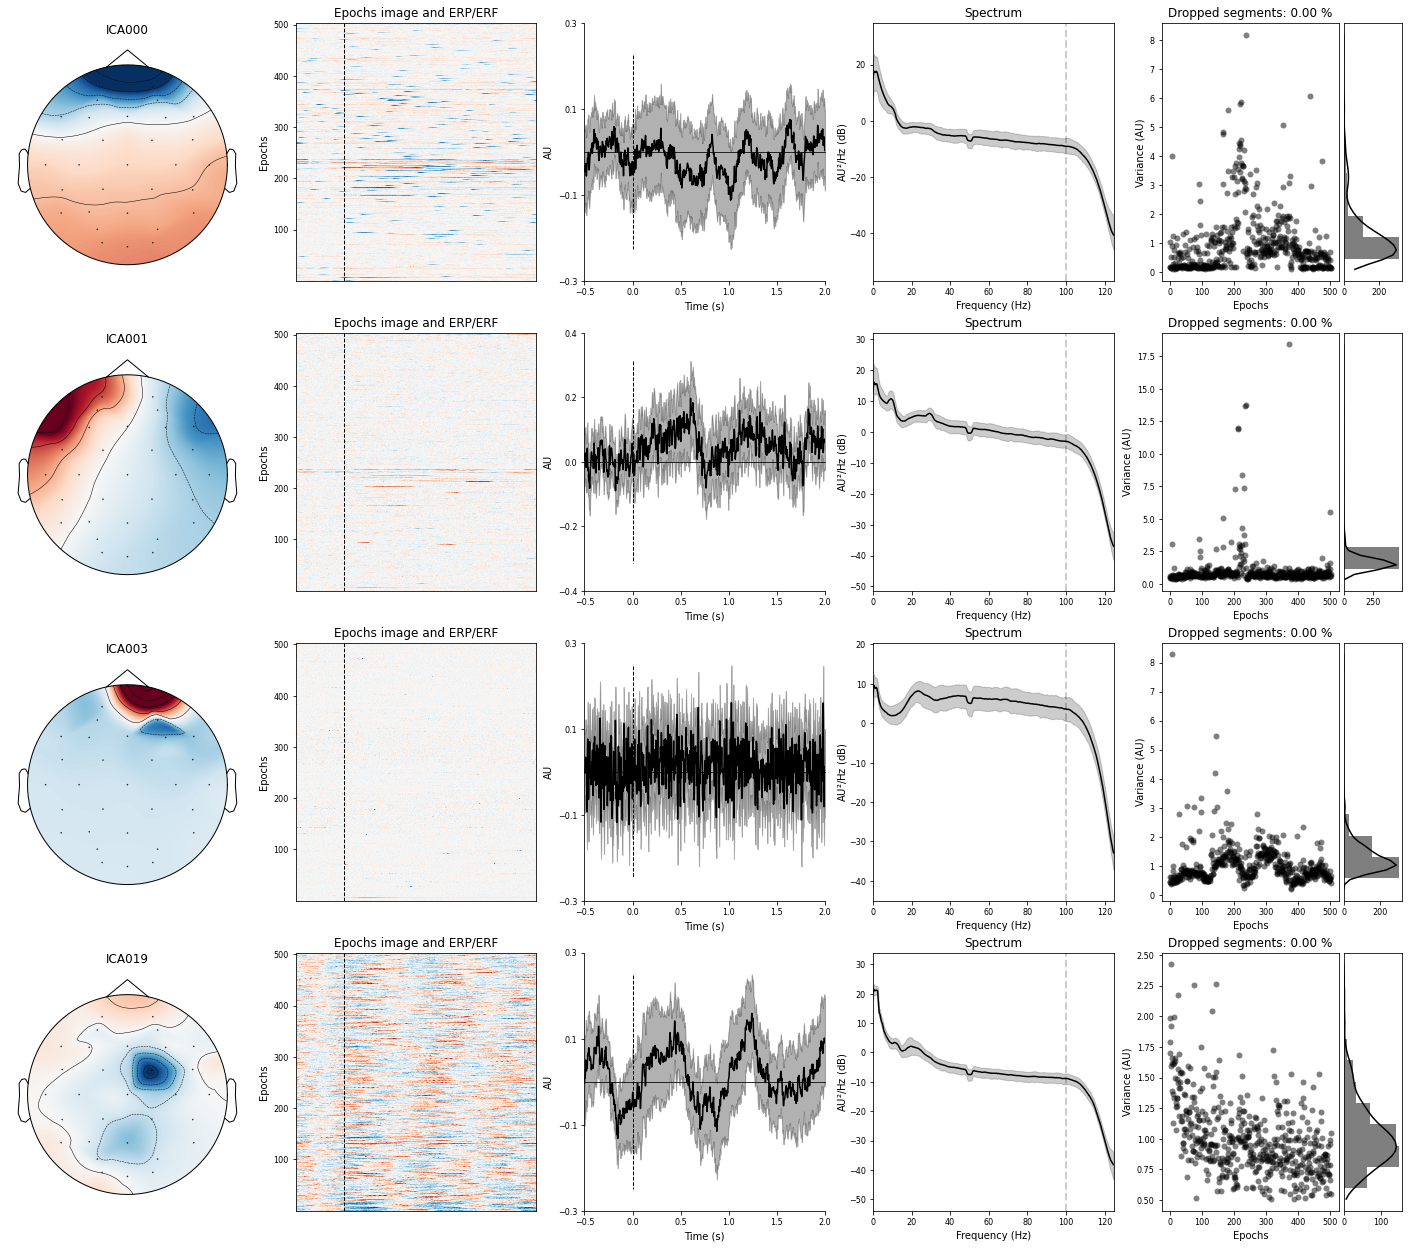

[] 0,1,3


In [35]:
%matplotlib inline 
fig, ax = plt.subplots(len(ica.exclude), 5, figsize = (25, len(ica.exclude)*5))
i = 0
for comp in ica.exclude:
    ica.plot_properties(epochs, picks=comp, axes=ax[i,:], show=False);
    i += 1
plt.show()
ica.exclude = [int(x) for x in input([]).split(',')]

In this example IC0, 1 and 3 are clearly related to eye activities and, because I do not care much about frontal electrodes, can be removed. ICA019 for example is a, very localized, brain source as it looks based on the centrality of the activity and the alpha/beta like frequency.

## Final exclusions of ICA components :

Visualize the consequence of the correction on the data without yet applying it

[0, 1, 3]
Applying ICA to Evoked instance
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 31 PCA components


/tmp/ipykernel_15891/1652067466.py:3: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.plot_overlay(epochs.average(), exclude=ica.exclude, picks='eeg');


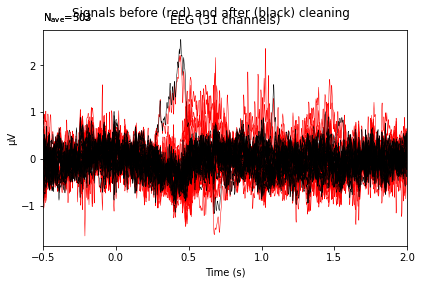

In [32]:
%matplotlib inline 
print(ica.exclude)
ica.plot_overlay(epochs.average(), exclude=ica.exclude, picks='eeg');

### Reloading original pre-ica data

In [33]:
raw = mne.io.read_raw_fif(EEG_data_path+"preprocessing/pre_ica_%s.fif"%name_subj, preload=True)

Opening raw data file ./preprocessing/pre_ica_S8.fif...
    Range : 0 ... 2779135 =      0.000 ...  2713.999 secs
Ready.
Reading 0 ... 2779135  =      0.000 ...  2713.999 secs...


/tmp/ipykernel_15891/1339611238.py:1: RuntimeWarning: This filename (./preprocessing/pre_ica_S8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(EEG_data_path+"preprocessing/pre_ica_%s.fif"%name_subj, preload=True)


You see here that we apply the ICA correction on the original raw data that wasn't downsampled

In [34]:
ica.apply(raw)


Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 31 PCA components


<Raw | pre_ica_S8.fif, 41 x 2779136 (2714.0 s), ~869.4 MB, data loaded>

## Interpolating the bad electrodes after ICA

Once we have done all that we can interpolate the bad channel we had

In [35]:
print(raw.info['bads'])
raw = raw.interpolate_bads()
raw.info['bads']


['P4']
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 31 sensor positions
Interpolating 1 sensors


[]

And take a look at the new frequency decomposition

Setting 378859 of 2779136 (13.63%) samples to NaN, retaining 2400277 (86.37%) samples.
Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


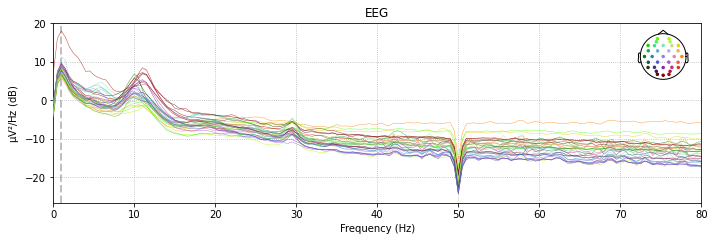

In [36]:
raw.plot_psd(fmax=80);

Save the post ICA correction

In [42]:
raw.save("preprocessing/post_ica_%s_raw.fif"%name_subj,overwrite=True)

Writing /home/gweindel/owncloud/projects/supervisions/2023/Kenneth_contrast/EEG_data/preprocessing/post_ica_S8_raw.fif
Closing /home/gweindel/owncloud/projects/supervisions/2023/Kenneth_contrast/EEG_data/preprocessing/post_ica_S8_raw.fif
[done]


# Auto-reject remaining artifacts

Autoreject (https://autoreject.github.io/v0.2/index.html) is a very useful tool for post-ICA preprocessing (but some also like to use it before, see the website). We first epoch the data and then try to find electrode-wise optimal thresholds based on a cross-validation method. The resulting solution is a way to interpolate electrodes that exceed their respective thresholds as long as no ttoo many of them have to be interpolated within a given trial (otherwise the trial is rejected)

## Creating epochs

The method works on epoched data, hence we first decompose the continuous data based on the stimulus triggers that were sent in the experiment

In [43]:
raw = mne.io.read_raw_fif(EEG_data_path+"preprocessing/post_ica_%s_raw.fif"%name_subj, preload=True)#reloading last step
events = mne.find_events(raw)

#In this decision-making experiment, triggers are condition (speed or accurate), side of the correct response (L/R), stimulus intensity, and response
#A description of a related design can be found here: Chapter 5 of https://thesiscommons.org/342zp
all_events = np.array(np.unique(events[:,2]))
stim_trigger_values = all_events[all_events<99]#stimulus intensity values
stim_id = {'stimulus/'+str(k):k for k in stim_trigger_values}#building dict on those
condition_id = {"condition/accuracy":101, "condition/speed":201}#condition trigger
side_id = {"side/left":99, "side/right":199}#Expected response side (correct answer)
resp_id = {"response/left":100,  "response/right":200}#Given esponse side events

event_id = condition_id | stim_id | side_id | resp_id #all retained events

tmin = -0.25 #tmin is how much data (in s) needs to be used for baseline correction
tmax = 2 #tmax is how much far in time from stim should we look for a response

stim = list(stim_id.keys())#values to center the epochs on

#here we create a metadata structure, very useful to use triggers outside of thos used for centering (here condition, side and response)
metadata, events, event_id = mne.epochs.make_metadata(
    events=events, event_id=event_id, tmin=tmin, tmax=tmax,
    sfreq=raw.info["sfreq"], row_events=stim, keep_first=["condition","side","stimulus","response"])

#In our case we are not interested in the specific timing of those events, just the nature of the first occurence of those so we can subselect the generated pandas dataframe
keep_cols = ['event_name', 'response', 'first_condition', 'first_side','first_stimulus','first_response']
metadata = metadata[keep_cols]
metadata.reset_index(drop=True, inplace=True)#This allows to preserve the trial number after the rejections performed by the mne.Epochs function
metadata.columns = ['event_name', 'rt', 'condition', 'side','stimulus','response']#More convenient names


#If you get a RuntimeWarning about no matching event found this is normal as sometime a few combinations are absent (e.g. no trial with accuracy condition, left expected response and contrast of 92)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                baseline=(None, 0), preload=True, 
                verbose=True, detrend=1, on_missing = 'warn', event_repeated='drop',
                metadata=metadata, reject_by_annotation=True, reject=None)

Not setting metadata
1116 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1116 events and 3585 original time points ...
13 bad epochs dropped


Epoch are dropped during the epoching because an artifact (or a break) was present between tmin and tmax. The following plot shows you how many, but more details can be found in ```epochs.drop_log()```

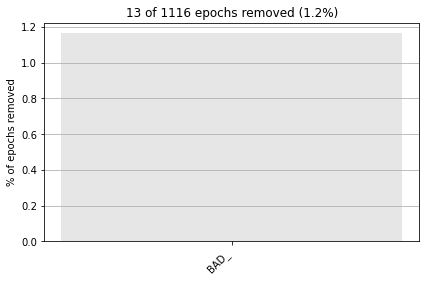

In [44]:
epochs.plot_drop_log();

## Auto-reject on remaining artifacts

Takes some time (and resources) to run

In [ ]:
import autoreject #version 0.3.1 https://autoreject.github.io/
ar = autoreject.AutoReject(consensus=np.linspace(0, .5, 11), n_jobs=-1) #I constrain the consensus parameter to be <=.5 as trials with more than half bad chan should be rejected
ar.fit(epochs)  # fit on the first 20 epochs to save time
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

The following plots summarize what was done by autoreject

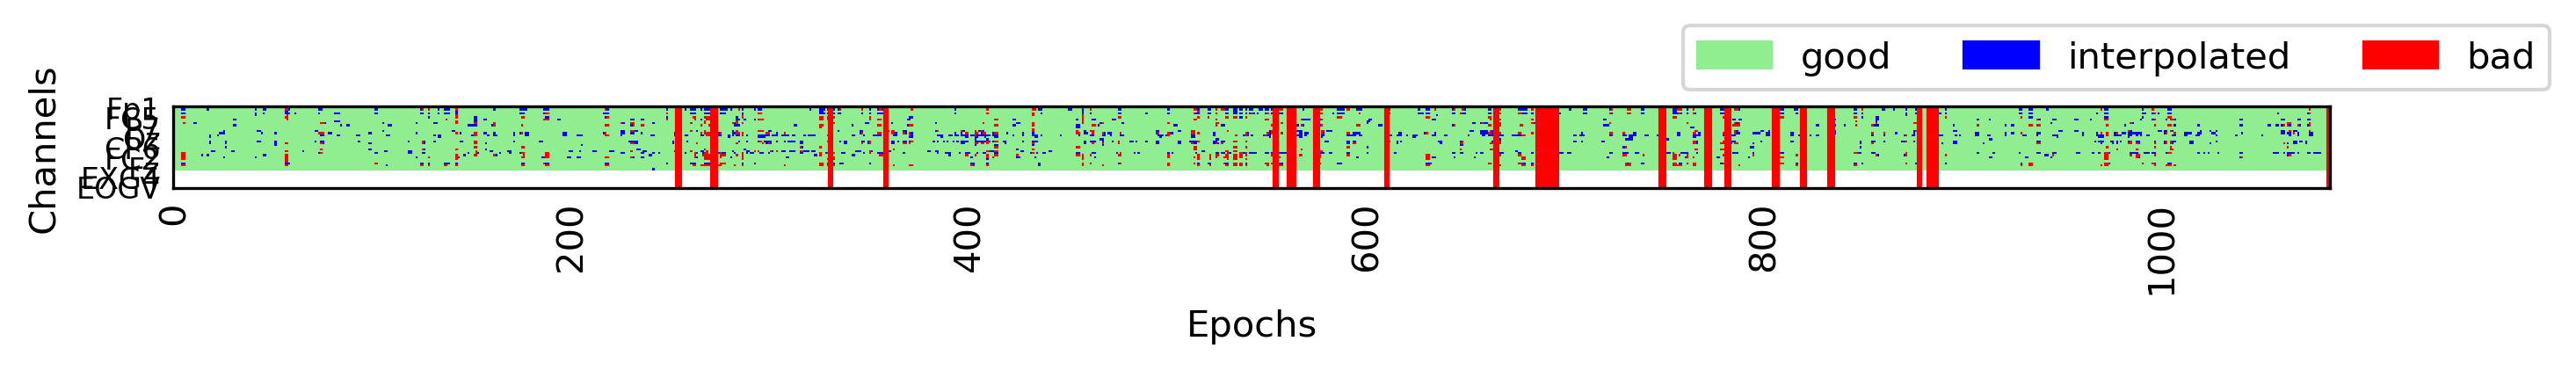

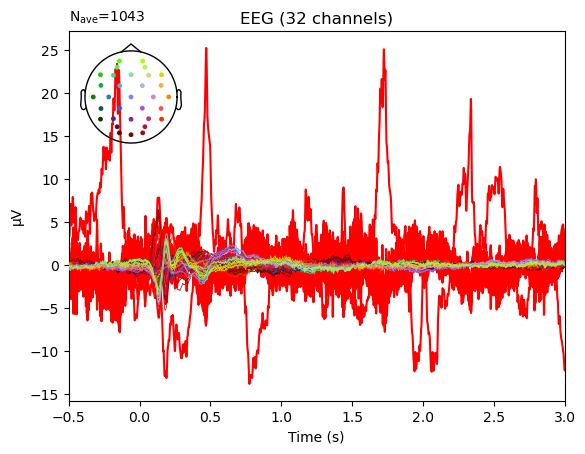

In [42]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(10,20), dpi=300)
reject_log.plot('horizontal', ax=ax)
plt.show()
evoked_bad = epochs[reject_log.bad_epochs].average()
plt.figure()
plt.plot(evoked_bad.times, evoked_bad.data.T * 1e6, 'r', zorder=-1)
epochs_ar.average().plot(axes=plt.gca());#Compare ERP of rejected vs not rejected

Now we can review what the algorithm did. If we don't agree with, e.g. when the trial was rejected rather than interpolated or the rejection threshold we can adjust the parameters in the ```AutoReject``` function

I would rather recommend to constrain the algortihm in such a way that it remains conservative so that eventually we mark some more trials as bad (as in the next cell) rather than automatically rejecting a lot of epochs.

In [43]:
%matplotlib qt
reject_log.plot_epochs(epochs,scalings=dict(eeg=100e-6))

Dropped 13 epochs: 57, 142, 152, 176, 187, 188, 262, 267, 268, 275, 276, 277, 292
The following epochs were marked as bad and are dropped:
[66, 162, 176, 200, 211, 212, 293, 298, 299, 306, 307, 308, 323]
Channels marked as bad:
none


The ```plot_drop_log()``` now shows the total amount of dropped epochs and those that come from the previous visual rejection and those rejected based on autoreject

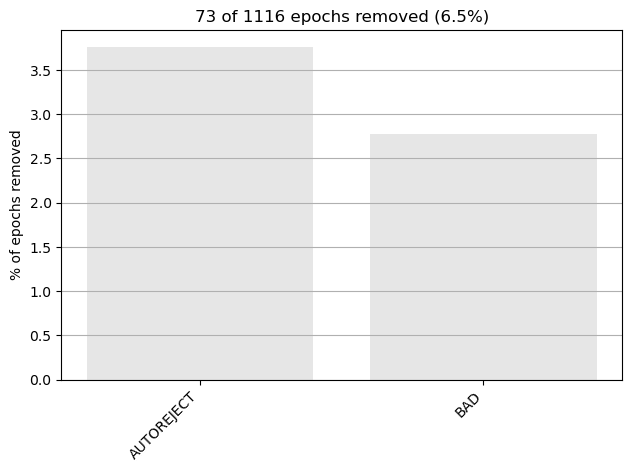

In [44]:
epochs_ar.plot_drop_log()

Then we save the data and can use them in further processing

In [46]:
epochs_ar.save('preprocessed/%s_epo.fif'%name_subj, overwrite=True)